# KAMA Explained Like Never Before

In this notebook, we’ll break down Kaufman’s Adaptive Moving Average (KAMA) from the ground up.  
You’ll learn:

- The intuition and logic behind its formula  
- How to implement it step-by-step in Python  
- How each parameter (`l1`, `l2`, `l3`) influences its behavior  
- And how to tune it to match your trading strategy

By the end, you won’t just be using KAMA — you’ll understand exactly how it thinks.


In [6]:
# Import the Features Engineering Package from Quantreo
import quantreo.features_engineering as fe

# Import Numpy & Pandas
import numpy as np
import pandas as pd

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [17]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()
df = df.loc["2016"]
price = df["close"].loc["2016-06":]

# Show the data
df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

## Create Your First KAMA

Let’s build KAMA from scratch.

In this section, you’ll implement the full calculation process step by step: the **Efficiency Ratio**, the **adaptive smoothing**, and the **recursive KAMA** update.

By the end, you’ll have your own working `kama()` function, **ready to plug into any strategy**.


In [4]:
def compute_er(price: np.ndarray, l1: int) -> np.ndarray:
    er = np.full_like(price, fill_value=np.nan, dtype=float)

    for t in range(l1, len(price)):
        change = abs(price[t] - price[t - l1])
        volatility = np.sum(np.abs(price[t - l1 + 1:t + 1] - price[t - l1:t]))
        er[t] = change / volatility if volatility != 0 else 0

    return er

def compute_sc(er: np.ndarray, l2: int, l3: int) -> np.ndarray:
    sc = np.full_like(er, fill_value=np.nan)

    sc_fast = 2 / (l2 + 1)
    sc_slow = 2 / (l3 + 1)

    for t in range(len(er)):
        if not np.isnan(er[t]):
            sc[t] = (er[t] * (sc_fast - sc_slow) + sc_slow) ** 2

    return sc

def compute_kama(price: np.ndarray, sc: np.ndarray, l1: int) -> np.ndarray:
    kama = np.full_like(price, fill_value=np.nan)

    for t in range(l1, len(price)):
        if t == l1:
            kama[t] = price[t]  # first point = price itself
        else:
            kama[t] = kama[t - 1] + sc[t] * (price[t] - kama[t - 1])

    return kama

def kama(price_series: pd.Series, l1=10, l2=2, l3=30) -> pd.Series:
    price = price_series.values
    er = compute_er(price, l1)
    sc = compute_sc(er, l2, l3)
    kama_values = compute_kama(price, sc, l1)
    return pd.Series(kama_values, index=price_series.index)

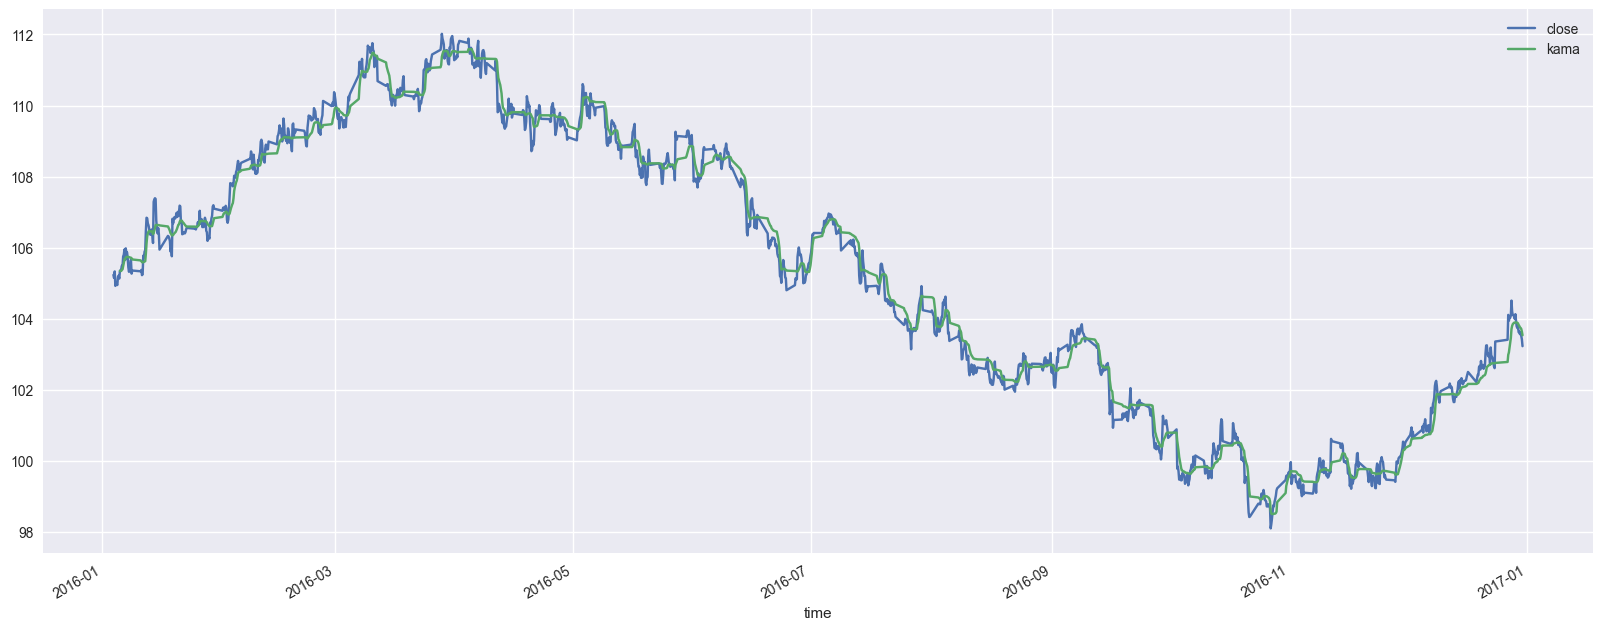

In [34]:
# Create the KAMA
df["kama"] = kama(df["close"])

# Plot the KAMA
df[["close","kama"]].plot(figsize=(20,8))
plt.show()

<br>

## Visualizing the Effect of KAMA Parameters

In this section, we isolate and vary each parameter (`l1`, `l2`, `l3`) to see how it changes the shape and reactivity of the KAMA curve, while keeping the others fixed.


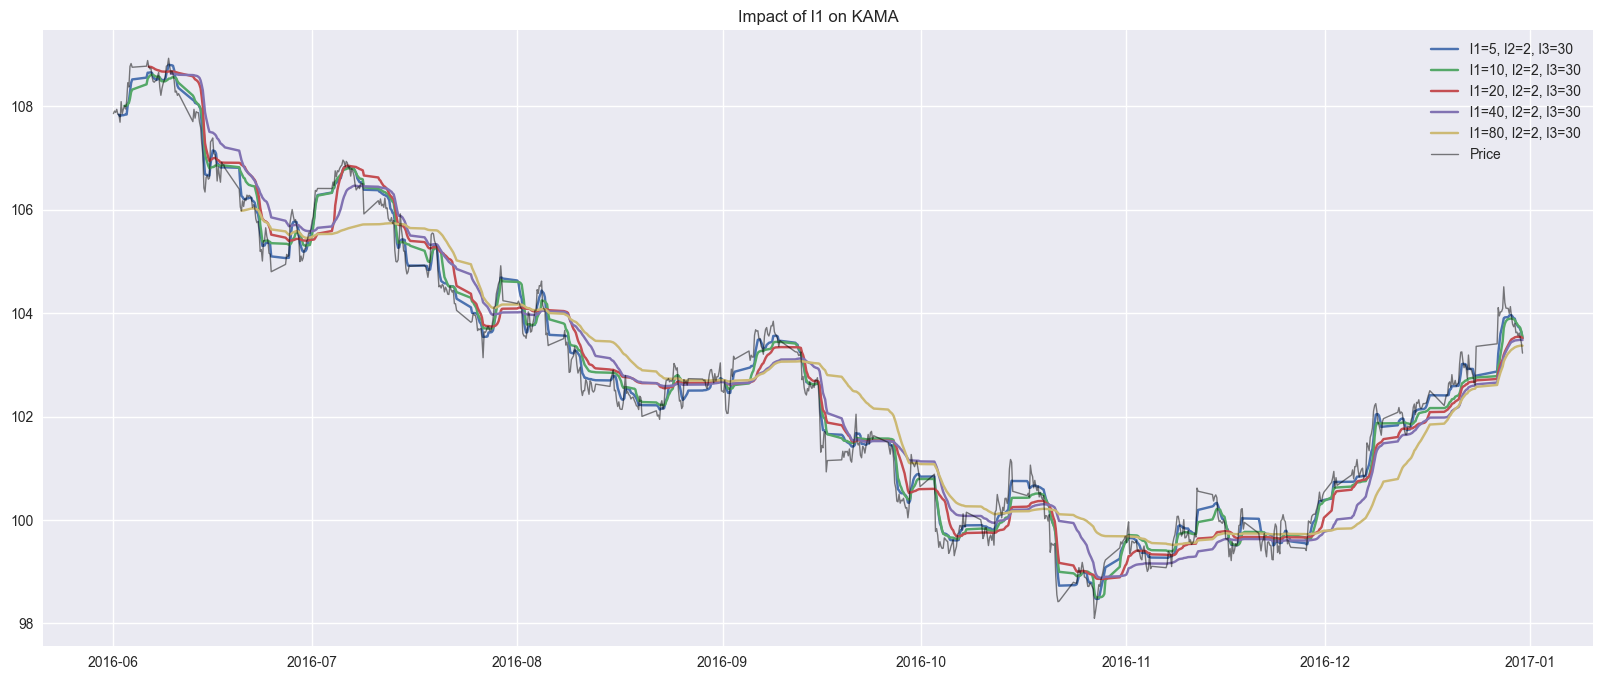

In [35]:
fig1, ax1 = plt.subplots(figsize=(20, 8))
l1_values = [5, 10, 20, 40, 80]
for l1 in l1_values:
    series = kama(price, l1=l1, l2=2, l3=30)
    ax1.plot(series, label=f"l1={l1}, l2=2, l3=30")
ax1.plot(price, label="Price", color="black", linewidth=1, alpha=0.5)
ax1.legend()
ax1.set_title("Impact of l1 on KAMA")
plt.show()

`l1` controls **how far back** KAMA looks to measure price efficiency.

- A **smaller `l1`** (like 5 or 10) makes KAMA **more reactive**, allowing it to follow short-term shifts — but it also becomes more sensitive to noise.
- A **larger `l1`** (like 40 or 80) smooths out the curve, reducing false signals — but introduces **more lag**.

**💡 Tip**: Use a short `l1` for reactive, intraday systems. Go longer if your goal is trend filtering over time.

<br>

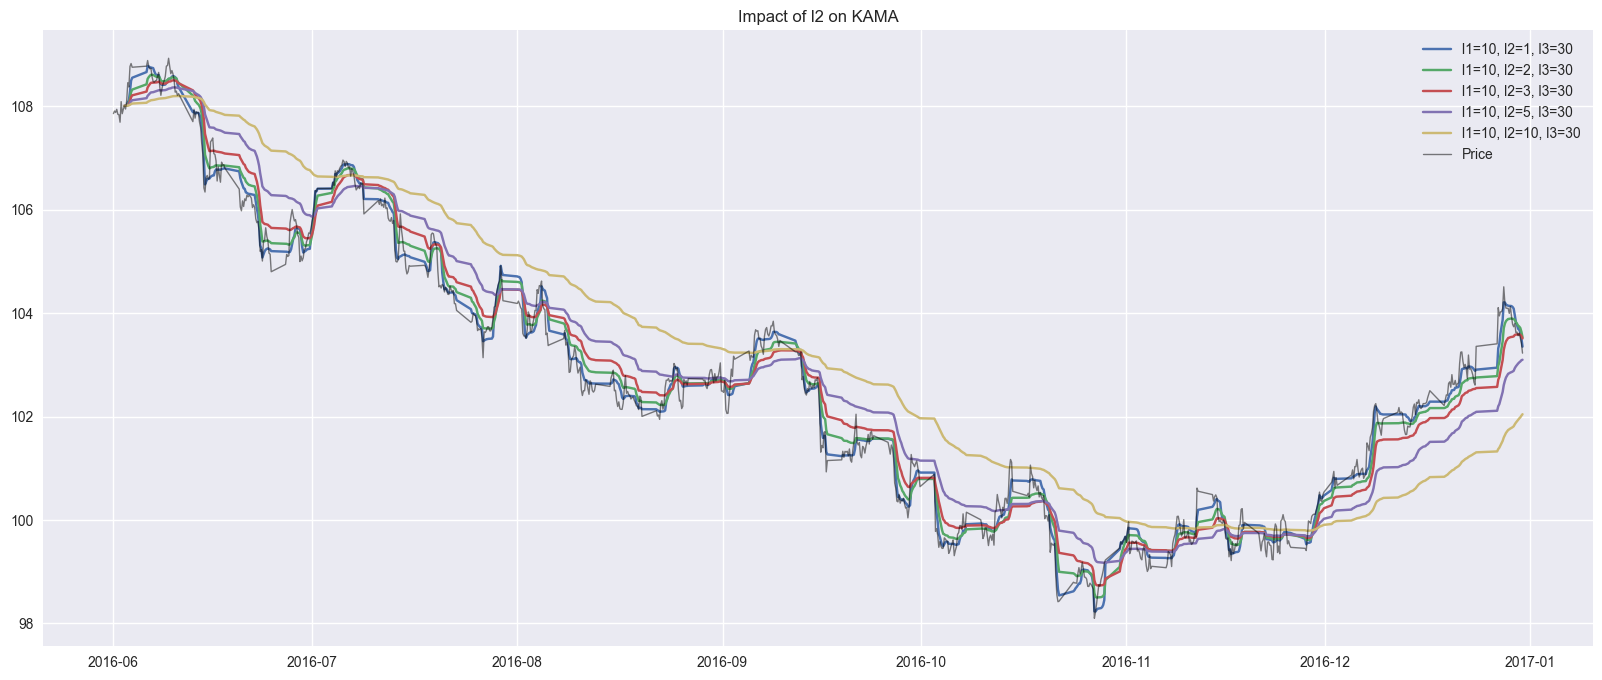

In [36]:
# 2. Impact of l2
fig2, ax2 = plt.subplots(figsize=(20, 8))
l2_values = [1, 2, 3, 5, 10]
for l2 in l2_values:
    series = kama(price, l1=10, l2=l2, l3=30)
    ax2.plot(series, label=f"l1=10, l2={l2}, l3=30")
ax2.plot(price, label="Price", color="black", linewidth=1, alpha=0.5)
ax2.legend()
ax2.set_title("Impact of l2 on KAMA")
plt.show()

`l2` defines the **maximum reactivity** of KAMA when the market is trending cleanly (Efficiency Ratio ≈ 1).

- A **low `l2`** (e.g. 1 or 2) gives KAMA the freedom to **respond quickly** during strong trends.
- A **higher `l2`** slows that reaction, even when the market is moving efficiently.

**💡 Tip**: A low `l2` is great for aggressive trend-following. Increase it if you want smoother transitions.

<br>

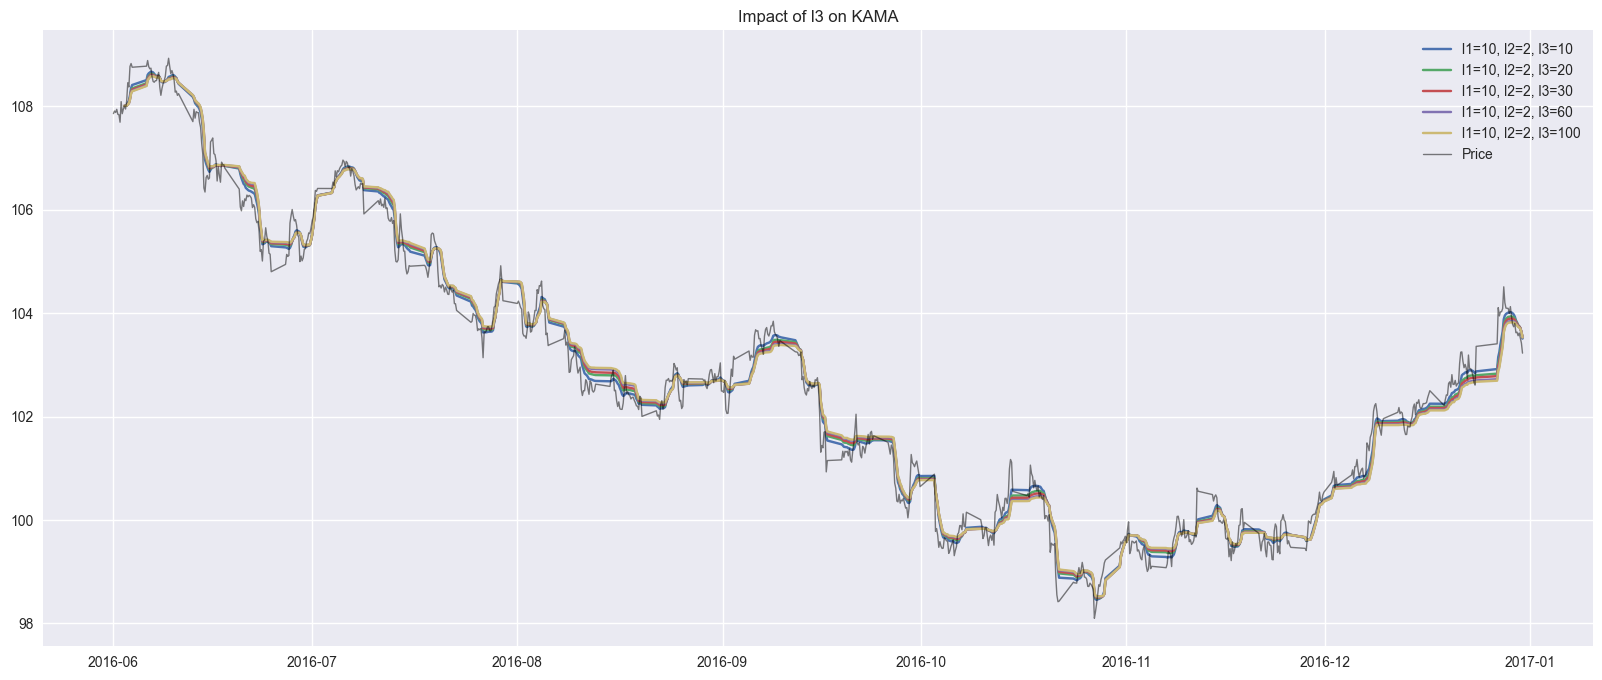

In [37]:
# 3. Impact of l3
fig3, ax3 = plt.subplots(figsize=(20, 8))
l3_values = [10, 20, 30, 60, 100]
for l3 in l3_values:
    series = kama(price, l1=10, l2=2, l3=l3)
    ax3.plot(series, label=f"l1=10, l2=2, l3={l3}")
ax3.plot(price, label="Price", color="black", linewidth=1, alpha=0.5)
ax3.legend()
ax3.set_title("Impact of l3 on KAMA")
plt.show()

`l3` sets the **minimum reactivity** of KAMA during sideways or noisy markets (Efficiency Ratio ≈ 0).

- With a **small `l3`**, KAMA still moves in uncertain environments, which might be useful for short-term plays.
- With a **larger `l3`**, KAMA becomes **much flatter**, ignoring minor fluctuations and helping you avoid false signals.

**💡 Tip**: If you want KAMA to sit still during choppy markets, increase `l3`. For more responsiveness in all conditions, lower it.

<br>

<br>

Kaufman’s Adaptive Moving Average (KAMA) is more than just a smoothing tool, it’s a dynamic filter that reacts intelligently to the market.

In this notebook, you’ve:

- Explored the mathematical logic behind KAMA  
- Implemented it step by step in Python  
- Visualized how each parameter (`l1`, `l2`, `l3`) impacts its behavior

You now have a solid foundation to **tune KAMA based on your strategy’s goals**, whether it’s filtering noise, following trends, or building adaptive indicators.

For production-ready use, you can directly access the optimized `kama()` function in the `quantreo.trend` module.